## Imports

In [1]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import movie_reviews, stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import pickle
from scipy.stats import spearmanr
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from typing import Callable

nltk.download("punkt_tab")
nltk.download("movie_reviews")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bxchi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\bxchi\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bxchi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bxchi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Setup

In [2]:
# Set seed for reproducibility
seed = 42

# Create folders
os.makedirs(os.path.normpath(os.path.join("..", "data")), exist_ok=True)
os.makedirs(os.path.normpath(os.path.join("..", "embedding_outputs")), exist_ok=True)
os.makedirs(os.path.normpath(os.path.join("..", "embedding_plots")), exist_ok=True)

## Helpers

### Visualisation

In [3]:
def visualise_embeddings(embeddings: np.ndarray, words: list[str], filename: str, seed: int = seed) -> None:
  # Use PCA to reduce dimensionality
  pca = PCA(n_components=2, random_state=seed)
  embeddings = pca.fit_transform(embeddings)

  # Plot the embeddings
  plt.figure(figsize=(12, 8))
  plt.scatter(embeddings[:, 0], embeddings[:, 1], marker="o")

  for i, word in enumerate(words):
      plt.annotate(word, xy=(embeddings[i, 0], embeddings[i, 1]), fontsize=10)

  plt.title("Embeddings from Movie Reviews (PCA)")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")

  # Save the plot
  plt.savefig(os.path.normpath(os.path.join("..", "embedding_plots", f"{filename}.png")))

  plt.show()

### WordSim-353 with Spearman Coefficient (For Hyperparameter Tuning)

In [4]:
# Load the WordSim-353 dataset into a dictionary of pairs to actual similarities
def load_wordsim353() -> dict[tuple[str, str], float]:
    wordsim353_df = pd.read_csv(os.path.normpath(os.path.join("..", "data", "wordsim353crowd.csv")))

    wordsim353_pairs_to_scores = dict()
    for _, row in wordsim353_df.iterrows():
      word_1, word_2 = sorted([row["Word 1"].lower(), row["Word 2"].lower()])
      score = row["Human (Mean)"]
      wordsim353_pairs_to_scores[(word_1, word_2)] = score
    
    return wordsim353_pairs_to_scores


# Get cosine similarity of two vectors
def cosine(vec_1: np.ndarray, vec_2: np.ndarray) -> float:
   return float(cosine_similarity([vec_1], [vec_2])[0][0])
   

# Get Spearman coefficient for a given model (set of hyperparams)
def eval_wordsim353(is_in_vocab: Callable, get_vector: Callable) -> dict[str, float | None]:
   wordsim353_pairs_to_scores = load_wordsim353()

   actual_sims, cos_sims = list(), list()
   num_pairs_in_vocab = 0

   # Loop through each word pair in WordSim-353
   for pair, actual_sim in wordsim353_pairs_to_scores.items():
      word_1, word_2 = pair

      # Check if the pair is present in model's vocab
      if is_in_vocab(word_1) and is_in_vocab(word_2):
         word_1_vec, word_2_vec = get_vector(word_1), get_vector(word_2)

         # Cosine similarity of the two word vectors
         cos_sim = cosine(vec_1=word_1_vec, vec_2=word_2_vec)

         # Update both the actual similarity from WordSim-353 and the cosine similarity
         actual_sims.append(actual_sim)
         cos_sims.append(cos_sim)

         num_pairs_in_vocab += 1
   
   if actual_sims:
      spearman_coeff, _ = spearmanr(actual_sims, cos_sims)
   
   else:
      spearman_coeff = None

   return {"coeff": spearman_coeff, "coverage": num_pairs_in_vocab / len(wordsim353_pairs_to_scores)}   

## Prepare Data

### Obtain Data

In [ ]:
# Get data from NLTK movie reviews
raw_reviews_with_labels = [
    {
        "tokens": list(movie_reviews.words(fileid)),
        "category": category
    }
    for category in movie_reviews.categories()
    for fileid in movie_reviews.fileids(category)
]

reviews_with_labels_df = pd.DataFrame(raw_reviews_with_labels)
reviews_with_labels_df["category"] = reviews_with_labels_df["category"].apply(lambda cat: 1 if cat == "pos" else 0)

In [6]:
reviews_with_labels_df

,tokens,category
0,"[plot, :, two, teen, couples, go, to, a, churc...",0
1,"[the, happy, bastard, ', s, quick, movie, revi...",0
2,"[it, is, movies, like, these, that, make, a, j...",0
3,"["", quest, for, camelot, "", is, warner, bros, ...",0
4,"[synopsis, :, a, mentally, unstable, man, unde...",0
...,...,...
1995,"[wow, !, what, a, movie, ., it, ', s, everythi...",1
1996,"[richard, gere, can, be, a, commanding, actor,...",1
1997,"[glory, --, starring, matthew, broderick, ,, d...",1
1998,"[steven, spielberg, ', s, second, epic, film, ...",1


### Data Processing

In [ ]:
def process_raw_data(reviews_with_labels_df: pd.DataFrame) -> None:
  # Get the list of raw tokens for each review
  raw_tokenised_reviews = list(reviews_with_labels_df["tokens"])

  # Process each token list
  stop_words = set(stopwords.words("english"))
  lemmatiser = WordNetLemmatizer()
  processed_tokenised_reviews = list()
  for tokens in raw_tokenised_reviews:
    processed_tokens_in_review = list()

    for token in tokens:
      # Convert to lowercase
      token = token.lower()

      # Only consider token if it completely consists of alphabets, and is not a stopword
      # Also ignore "br" - may correspond to html <br> tag
      if token.isalpha() and token not in stop_words and token != "br":
        # Lemmatise the word (change to root form)
        token = lemmatiser.lemmatize(token)
        processed_tokens_in_review.append(token)

    processed_tokenised_reviews.append(processed_tokens_in_review)

  # Modify "tokens" column to the processed version
  reviews_with_labels_df["tokens"] = processed_tokenised_reviews

In [8]:
process_raw_data(reviews_with_labels_df=reviews_with_labels_df)

In [9]:
reviews_with_labels_df

,tokens,category
0,"[plot, two, teen, couple, go, church, party, d...",0
1,"[happy, bastard, quick, movie, review, damn, b...",0
2,"[movie, like, make, jaded, movie, viewer, than...",0
3,"[quest, camelot, warner, bros, first, feature,...",0
4,"[synopsis, mentally, unstable, man, undergoing...",0
...,...,...
1995,"[wow, movie, everything, movie, funny, dramati...",1
1996,"[richard, gere, commanding, actor, always, gre...",1
1997,"[glory, starring, matthew, broderick, denzel, ...",1
1998,"[steven, spielberg, second, epic, film, world,...",1


### Data Exploration

In [10]:
# Check word counts
def get_common_words(reviews_with_labels_df: pd.DataFrame, num_words: int) -> tuple[dict[str, int], list[str]]:
  # Count occurrences of words in corpus
  word_counts = dict()
  for review in list(reviews_with_labels_df["tokens"]):
    for word in review:
      if word not in word_counts:
        word_counts[word] = 0
      word_counts[word] += 1

  most_common_words = sorted(word_counts.keys(), key=lambda x: word_counts[x], reverse=True)[:num_words]
  return word_counts, most_common_words

In [11]:
word_counts, most_common_words = get_common_words(reviews_with_labels_df=reviews_with_labels_df, num_words=50)
print("Most common words:")
for word in most_common_words:
  print(f"{word}: Count = {word_counts[word]}")

Most common words:
film: Count = 11053
movie: Count = 6977
one: Count = 6028
character: Count = 3879
like: Count = 3789
time: Count = 2979
get: Count = 2814
scene: Count = 2671
make: Count = 2634
even: Count = 2568
good: Count = 2429
story: Count = 2345
would: Count = 2109
much: Count = 2049
also: Count = 1967
well: Count = 1921
life: Count = 1913
two: Count = 1911
see: Count = 1885
way: Count = 1882
first: Count = 1836
go: Count = 1760
year: Count = 1732
thing: Count = 1661
take: Count = 1579
plot: Count = 1574
really: Count = 1558
come: Count = 1510
little: Count = 1505
know: Count = 1494
people: Count = 1470
could: Count = 1427
man: Count = 1404
bad: Count = 1395
work: Count = 1379
never: Count = 1374
director: Count = 1347
best: Count = 1334
end: Count = 1328
performance: Count = 1317
new: Count = 1292
look: Count = 1278
many: Count = 1268
action: Count = 1260
actor: Count = 1252
u: Count = 1225
love: Count = 1209
play: Count = 1205
star: Count = 1160
role: Count = 1155


In [12]:
# Conduct train-test split before experimentation (avoid data leakage)
TESTSET_SIZE = 0.2

reviews_train, reviews_test, labels_train, labels_test = train_test_split(reviews_with_labels_df["tokens"], reviews_with_labels_df["category"], test_size=0.2, random_state=seed)
reviews_train, reviews_test, labels_train, labels_test = list(reviews_train), list(reviews_test), list(labels_train), list(labels_test)

In [13]:
# Save processed tokens and most common word list (can be loaded for use in Glove workflow)
with open(os.path.normpath(os.path.join("..", "data", "reviews_train.pkl")), "wb") as f:
  pickle.dump(reviews_train, f)

with open(os.path.normpath(os.path.join("..", "data", "reviews_test.pkl")), "wb") as f:
  pickle.dump(reviews_test, f)

with open(os.path.normpath(os.path.join("..", "data", "most_common_words.pkl")), "wb") as f:
  pickle.dump(most_common_words, f)

# Save labels
with open(os.path.normpath(os.path.join("..", "data", "labels_train.pkl")), "wb") as f:
  pickle.dump(labels_train, f)

with open(os.path.normpath(os.path.join("..", "data", "labels_test.pkl")), "wb") as f:
  pickle.dump(labels_test, f)

In [6]:
# Select common words for analysis later
TEST_WORDS = ["film", "like", "good", "time", "story", "character", "life", "scene"]

## Skip-Gram (Word2Vec)

In [15]:
WORD2VEC_MIN_COUNT = 1
WORD2VEC_EPOCHS = 20

### Fixed Set of Parameters

#### Algorithm

In [16]:
WORD2VEC_VECTOR_SIZE = 50
WORD2VEC_WINDOW = 3
WORD2VEC_NEGATIVE = 5

In [17]:
# Fit the model and get the embeddings
word2vec_model = Word2Vec(sentences=reviews_train, vector_size=WORD2VEC_VECTOR_SIZE, window=WORD2VEC_WINDOW, min_count=WORD2VEC_MIN_COUNT, epochs=WORD2VEC_EPOCHS, workers=12, sg=1, negative=WORD2VEC_NEGATIVE, seed=seed)
word2vec_embeddings = word2vec_model.wv

# Save model
with open(os.path.normpath(os.path.join("..", "embedding_outputs", "word2vec_model.pkl")), "wb") as f:
    pickle.dump(word2vec_model, f)

#### Visualisation

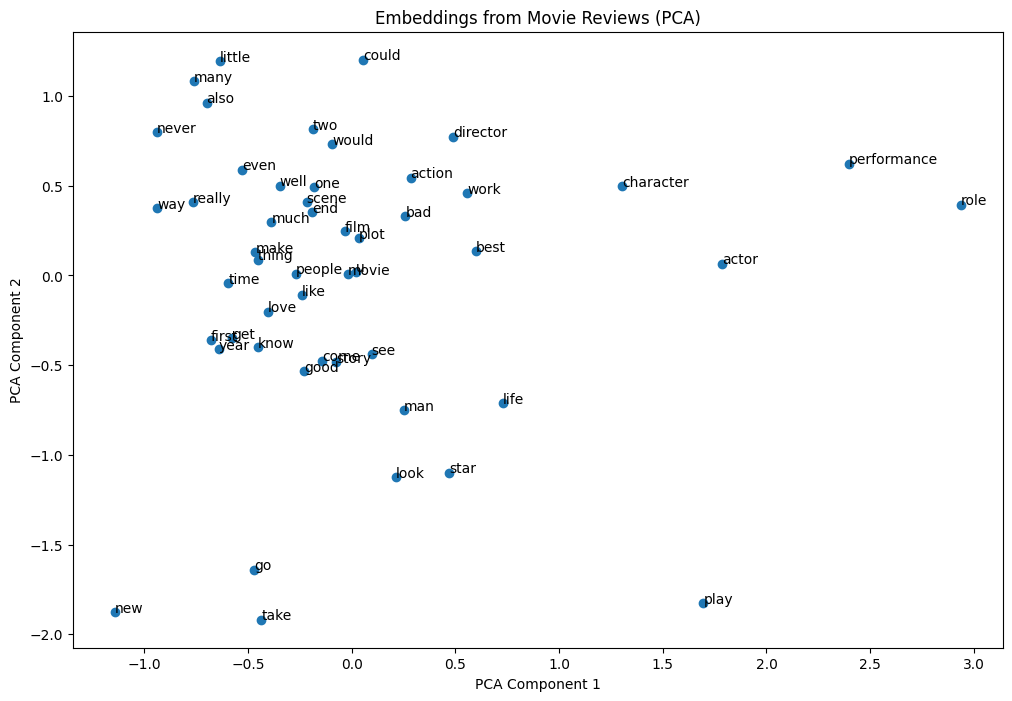

In [18]:
# Only visualise the embeddings of the most common words in the corpus
most_common_word2vec_embeddings = np.array([word2vec_embeddings[word] for word in most_common_words])
visualise_embeddings(embeddings=most_common_word2vec_embeddings, words=most_common_words, filename="word2vec_pca_visualisation")

#### Nearest Neighbours

In [19]:
# Check nearest words
WORD2VEC_TOPN = 10

for word in TEST_WORDS:
  print(f"{WORD2VEC_TOPN} nearest neighbours to {word}:")
  print(word2vec_model.wv.most_similar(word, topn=WORD2VEC_TOPN))
  print()

10 nearest neighbours to film:
[('movie', 0.9044820666313171), ('unsatisfactory', 0.8606497645378113), ('expanded', 0.8437156677246094), ('mant', 0.8396050333976746), ('emphatically', 0.8351638913154602), ('putrid', 0.8332487940788269), ('unmistakable', 0.8327082991600037), ('shoo', 0.8282871842384338), ('voted', 0.8277428150177002), ('quieter', 0.8270278573036194)]

10 nearest neighbours to like:
[('synch', 0.7804538607597351), ('embarrassed', 0.7312526106834412), ('sake', 0.7308354377746582), ('kinship', 0.7269320487976074), ('xerox', 0.7237459421157837), ('foodstuff', 0.7236295938491821), ('bloodbath', 0.7207787036895752), ('yammering', 0.7204863429069519), ('humourous', 0.7190214991569519), ('culp', 0.7170007824897766)]

10 nearest neighbours to good:
[('decent', 0.7957882881164551), ('eas', 0.7387107610702515), ('great', 0.7342360019683838), ('terrible', 0.7264418601989746), ('paled', 0.7233241200447083), ('bad', 0.7233129143714905), ('mastering', 0.7232654690742493), ('decieving'

### Trying out Hyperparameter Tuning

#### Algorithm

In [20]:
WORD2VEC_VECTOR_SIZES = [50, 100, 150]
WORD2VEC_WINDOWS = [3, 5, 10]
WORD2VEC_NEGATIVES = [3, 5, 10]

In [21]:
word2vec_max_spearman_coeff = -10
word2vec_best_vector_size, word2vec_best_window, word2vec_best_negative = None, None, None

# Iterate through each possible set of hyperparameters, finding the best set (metric: Spearman coefficient + WordSim-353)
for vector_size in WORD2VEC_VECTOR_SIZES:
  for window in WORD2VEC_WINDOWS:
    for negative in WORD2VEC_NEGATIVES:
      # Run algorithm
      print(f"Vector size: {vector_size} | Window: {window} | Negative: {negative}")
      word2vec_model_ht = Word2Vec(sentences=reviews_train, vector_size=vector_size, window=window, min_count=WORD2VEC_MIN_COUNT, epochs=WORD2VEC_EPOCHS, workers=12, sg=1, negative=negative, seed=seed)
      word2vec_embeddings_ht = word2vec_model_ht.wv
      
      # Evaluate by getting Spearman coefficient using WordSim-353
      eval_output = eval_wordsim353(is_in_vocab=lambda word: word in word2vec_embeddings_ht.key_to_index, get_vector=lambda word: word2vec_embeddings_ht[word])
      spearman_coeff, coverage = eval_output["coeff"], eval_output["coverage"]
      print(f"Spearman coefficient: {spearman_coeff} | Coverage: {coverage}\n")

      if spearman_coeff is not None and spearman_coeff > word2vec_max_spearman_coeff:
        # Best hyperparams so far
        word2vec_max_spearman_coeff = spearman_coeff
        word2vec_best_vector_size, word2vec_best_window, word2vec_best_negative = vector_size, window, negative
      
        # Save best model
        with open(os.path.normpath(os.path.join("..", "embedding_outputs", "word2vec_model_ht.pkl")), "wb") as f:
          pickle.dump(word2vec_model_ht, f)

print(f"Max Spearman coefficient: {word2vec_max_spearman_coeff} | Best vector size: {word2vec_best_vector_size} | Best window: {word2vec_best_window} | Best negative: {word2vec_best_negative}")

Vector size: 50 | Window: 3 | Negative: 3
Spearman coefficient: 0.22995677899214922 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 3 | Negative: 5
Spearman coefficient: 0.22946362369808587 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 3 | Negative: 10
Spearman coefficient: 0.23191778675525399 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 5 | Negative: 3
Spearman coefficient: 0.2302448331147119 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 5 | Negative: 5
Spearman coefficient: 0.2354567670299349 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 5 | Negative: 10
Spearman coefficient: 0.24764815486513364 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 10 | Negative: 3
Spearman coefficient: 0.256373561022586 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 10 | Negative: 5
Spearman coefficient: 0.265381629360782 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 10 | Negative: 10
Spearman coefficient: 0.271186

In [22]:
# Load best model and embeddings
with open(os.path.normpath(os.path.join("..", "embedding_outputs", "word2vec_model_ht.pkl")), "rb") as f:
  word2vec_model_ht = pickle.load(f)

word2vec_embeddings_ht = word2vec_model_ht.wv

#### Visualisation

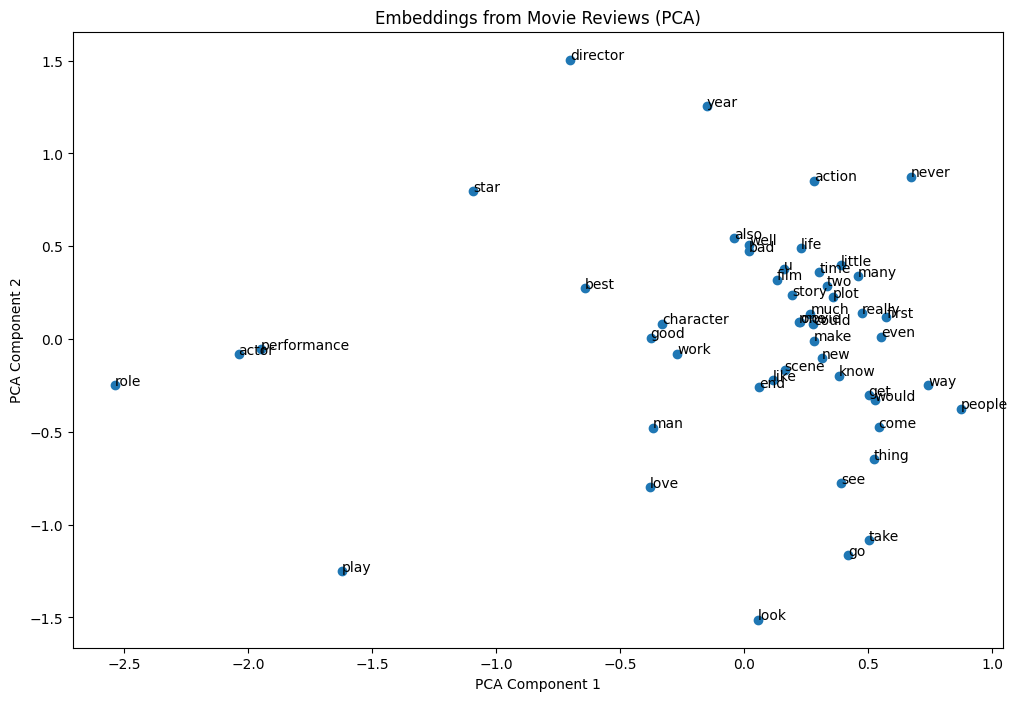

In [23]:
# Only visualise the embeddings of the most common words in the corpus
most_common_word2vec_embeddings_ht = np.array([word2vec_embeddings_ht[word] for word in most_common_words])
visualise_embeddings(embeddings=most_common_word2vec_embeddings_ht, words=most_common_words, filename="word2vec_ht_pca_visualisation")

#### Nearest Neighbours

In [24]:
# Check nearest words
WORD2VEC_TOPN = 10

for word in TEST_WORDS:
  print(f"{WORD2VEC_TOPN} nearest neighbours to {word}:")
  print(word2vec_model_ht.wv.most_similar(word, topn=WORD2VEC_TOPN))
  print()

10 nearest neighbours to film:
[('movie', 0.8113678097724915), ('rejuvenates', 0.7720246315002441), ('godforsaken', 0.7709106206893921), ('unconventionality', 0.7676049470901489), ('horor', 0.7661639451980591), ('circled', 0.7618758082389832), ('chequered', 0.7570934891700745), ('voil', 0.7546131610870361), ('unsentimental', 0.7523300051689148), ('kafkaism', 0.75039142370224)]

10 nearest neighbours to like:
[('ewwwww', 0.6563647985458374), ('unflushed', 0.6562364101409912), ('interferred', 0.6544751524925232), ('glisten', 0.6513232588768005), ('cagney', 0.648890495300293), ('anothergreat', 0.6481334567070007), ('prefered', 0.6474140882492065), ('peacenik', 0.6471408009529114), ('shalit', 0.644629180431366), ('amateurism', 0.6434406638145447)]

10 nearest neighbours to good:
[('expended', 0.6557424664497375), ('commensurate', 0.6325111985206604), ('imaganitive', 0.6225097179412842), ('bregman', 0.618292510509491), ('faulted', 0.6158546209335327), ('decieving', 0.6107174158096313), ('ex

## SPPMI-SVD

In [25]:
### Functions for Algorithm ###
def get_co_occurrence_matrix(reviews: list[list[str]], window_size: int) -> tuple[np.ndarray, dict[str, int]]:
  # Get all unique words in the corpus, mapped to a unique int id
  vocab = {word: id for id, word in enumerate(set(word for review in reviews for word in review))}

  # Initialise co-occurrence matrix
  vocab_size = len(vocab)
  co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

  # Populate the co-occurrence matrix with the window
  for review in reviews:
      review_length = len(review)
      for current_word_index, current_word in enumerate(review):
          current_word_id = vocab[current_word]

          # Find the endpoints of the context window (using window size)
          start = max(0, current_word_index - window_size)
          end = min(review_length, current_word_index + window_size + 1)

          # Update co-occurrence counts for words in the window
          for context_word_index in range(start, end):
              if current_word_index != context_word_index:  # Skip the word itself
                  context_word_id = vocab[review[context_word_index]]
                  co_occurrence_matrix[current_word_id, context_word_id] += 1

  return co_occurrence_matrix, vocab


def conduct_sppmi_svd(reviews: list[list[str]], window_size: int, negative: int, vector_size: int, seed: int = seed) -> tuple[np.ndarray, dict[str, int]]:
  # Get co-occurence matrix
  co_occurrence_matrix, vocab = get_co_occurrence_matrix(reviews=reviews, window_size=window_size)
  print("Co-occurrence matrix populated!")

  # Initialise SPPMI matrix
  sppmi_matrix = np.zeros_like(co_occurrence_matrix)

  # Populate SPPMI matrix
  # Find indices where entries of co-occurrence matrix are positive
  row_indices_non_zero, col_indices_non_zero = np.nonzero(co_occurrence_matrix)

  co_occurrence_matrix_sum = np.sum(co_occurrence_matrix)
  marginal_probs = np.sum(co_occurrence_matrix, axis=1) / co_occurrence_matrix_sum
  for i, j in zip(row_indices_non_zero, col_indices_non_zero):
    if co_occurrence_matrix[i, j] > 0:
        pmi = np.log((co_occurrence_matrix[i, j] / co_occurrence_matrix_sum) / (marginal_probs[i] * marginal_probs[j]))
        sppmi_matrix[i, j] = max(pmi - np.log(negative), 0)

  print("SPPMI matrix populated!")

  # Apply SVD on the SPPMI matrix
  svd = TruncatedSVD(n_components=vector_size, random_state=seed)
  sppmi_svd_embeddings = svd.fit_transform(sppmi_matrix)

  print("SPPMI-SVD embeddings produced!")

  return sppmi_svd_embeddings, vocab

In [3]:
### Nearest Neighbours ###
def sppmi_svd_nearest_neighbours(embeddings: np.ndarray, words_to_ids: dict[str, int], target_word: str, topn: int) -> list[tuple[str, float]]:
  # Get embedding of target word
  if target_word not in words_to_ids:
    raise KeyError(f"word {target_word} not in vocabulary")

  target_word_id = words_to_ids[target_word]
  target_word_embedding = np.array([embeddings[target_word_id]])

  # Array of cosine similarities to target word (each element is itself an array of length 1)
  similarities = cosine_similarity(embeddings, target_word_embedding)

  # Organise similarity of each word to the target word
  ids_to_words = {id: word for word, id in words_to_ids.items()}
  word_similarity_pairs = list()
  for i, packed_similarity in enumerate(similarities):
    # Skip the target word itself (don't need to consider similarity with itself)
    if i != target_word_id:
      word = ids_to_words[i]
      word_similarity_pairs.append((word, packed_similarity.item()))

  # Sort in order of decreasing similarity
  word_similarity_pairs.sort(key=lambda pair: pair[1], reverse=True)

  return word_similarity_pairs[:topn]

### Fixed Set of Hyperparameters

#### Algorithm

In [27]:
SPPMI_SVD_VECTOR_SIZE = 50
SPPMI_SVD_WINDOW = 3
SPPMI_SVD_NEGATIVE = 5

In [28]:
# Conduct the algorithm
sppmi_svd_embeddings, sppmi_svd_words_to_ids = conduct_sppmi_svd(reviews=reviews_train, window_size=window, negative=negative, vector_size=vector_size)

# Save best embeddings and mapping
with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings.pkl")), "wb") as f:
    pickle.dump(sppmi_svd_embeddings, f)

with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_mapping.pkl")), "wb") as f:
    pickle.dump(sppmi_svd_words_to_ids, f)

Co-occurrence matrix populated!
SPPMI matrix populated!
SPPMI-SVD embeddings produced!


#### Visualisation

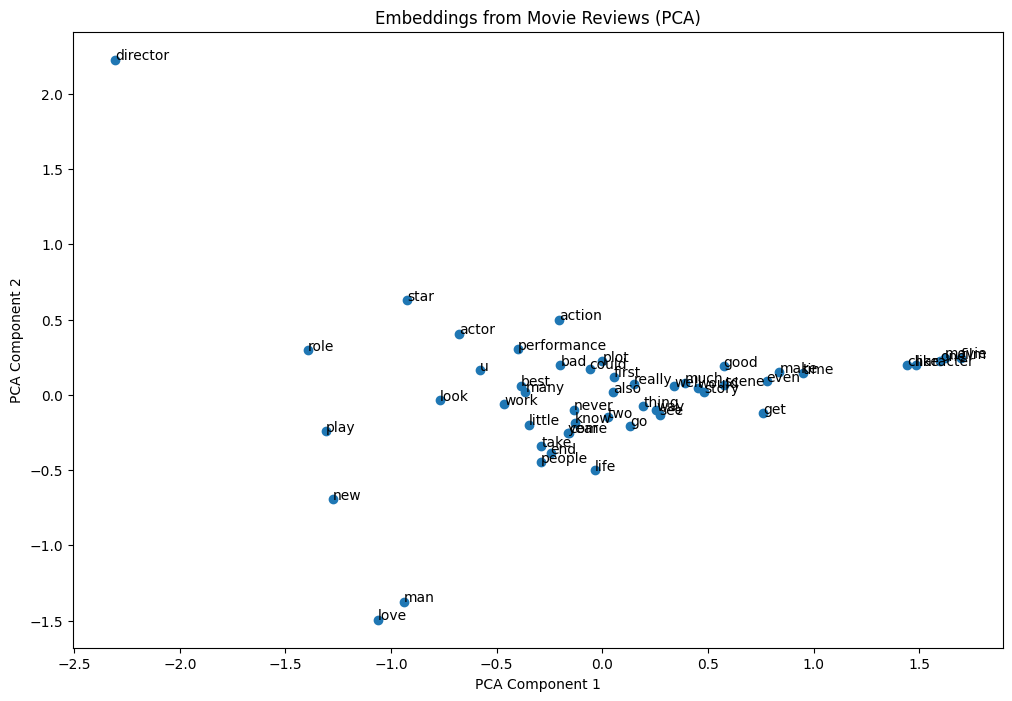

In [29]:
# Only visualise the embeddings of the most common words in the corpus
most_common_sppmi_svd_embeddings = np.array([sppmi_svd_embeddings[sppmi_svd_words_to_ids[word]] for word in most_common_words])    # Use the unique int id of the word to get the corresponding embedding (with the words_to_id mapping)
visualise_embeddings(embeddings=most_common_sppmi_svd_embeddings, words=most_common_words, filename="sppmi_svd_pca_visualisation")

#### Nearest Neighbours

In [9]:
# Check nearest neighbours
SPPMI_SVD_TOPN = 10

for word in TEST_WORDS:
  print(f"{SPPMI_SVD_TOPN} nearest neighbours to {word}:")
  print(sppmi_svd_nearest_neighbours(embeddings=sppmi_svd_embeddings, words_to_ids=sppmi_svd_words_to_ids, target_word=word, topn=SPPMI_SVD_TOPN))
  print()

10 nearest neighbours to film:
[('interferred', 0.6822568774223328), ('aspired', 0.6196185946464539), ('script', 0.5980833172798157), ('movie', 0.5884255170822144), ('look', 0.583650529384613), ('predictable', 0.5759027004241943), ('anything', 0.57457035779953), ('thriller', 0.5741803646087646), ('often', 0.5649411678314209), ('could', 0.5646660923957825)]

10 nearest neighbours to like:
[('come', 0.7138094902038574), ('think', 0.7136224508285522), ('watching', 0.711866557598114), ('get', 0.6969590187072754), ('see', 0.6953395009040833), ('every', 0.6942891478538513), ('everyone', 0.6931802034378052), ('time', 0.692459225654602), ('well', 0.6812885403633118), ('something', 0.6792770624160767)]

10 nearest neighbours to good:
[('time', 0.8700373768806458), ('bad', 0.8630803823471069), ('much', 0.858633279800415), ('little', 0.8566007614135742), ('make', 0.848146378993988), ('even', 0.8455625772476196), ('really', 0.8454145193099976), ('better', 0.8443527817726135), ('know', 0.8398519158

### Trying out Hyperparameter Tuning

#### Algorithm

In [31]:
SPPMI_SVD_NEGATIVES = [3, 5, 10]
SPPMI_SVD_WINDOWS = [3, 5, 10]
SPPMI_SVD_VECTOR_SIZES = [50, 100, 150]

In [32]:
sppmi_svd_max_spearman_coeff = -10
sppmi_svd_best_vector_size, sppmi_svd_best_window, sppmi_svd_best_negative = None, None, None

# Iterate through each possible set of hyperparameters, finding the best set (metric: Spearman coefficient + WordSim-353)
for vector_size in SPPMI_SVD_VECTOR_SIZES:
  for window in SPPMI_SVD_WINDOWS:
    for negative in SPPMI_SVD_NEGATIVES:
      # Run algorithm
      print(f"Vector size: {vector_size} | Window: {window} | Negative: {negative}")
      sppmi_svd_embeddings_ht, sppmi_svd_words_to_ids_ht = conduct_sppmi_svd(reviews=reviews_train, window_size=window, negative=negative, vector_size=vector_size)
      
      # Evaluate by getting Spearman coefficient using WordSim-353
      eval_output = eval_wordsim353(is_in_vocab=lambda word: word in sppmi_svd_words_to_ids_ht, get_vector=lambda word: sppmi_svd_embeddings_ht[sppmi_svd_words_to_ids_ht[word]])
      spearman_coeff, coverage = eval_output["coeff"], eval_output["coverage"]
      print(f"Spearman coefficient: {spearman_coeff} | Coverage: {coverage}\n")

      if spearman_coeff is not None and spearman_coeff > sppmi_svd_max_spearman_coeff:
        # Best hyperparams so far
        sppmi_svd_max_spearman_coeff = spearman_coeff
        sppmi_svd_best_vector_size, sppmi_svd_best_window, sppmi_svd_best_negative = vector_size, window, negative
      
        # Save best embeddings and mapping
        with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_ht.pkl")), "wb") as f:
          pickle.dump(sppmi_svd_embeddings_ht, f)

        with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_mapping_ht.pkl")), "wb") as f:
          pickle.dump(sppmi_svd_words_to_ids_ht, f)

print(f"Max Spearman coefficient: {sppmi_svd_max_spearman_coeff} | Best vector size: {sppmi_svd_best_vector_size} | Best window: {sppmi_svd_best_window} | Best negative: {sppmi_svd_best_negative}")

Vector size: 50 | Window: 3 | Negative: 3
Co-occurrence matrix populated!
SPPMI matrix populated!
SPPMI-SVD embeddings produced!
Spearman coefficient: 0.18507943985000597 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 3 | Negative: 5
Co-occurrence matrix populated!
SPPMI matrix populated!
SPPMI-SVD embeddings produced!
Spearman coefficient: 0.21158995871514277 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 3 | Negative: 10
Co-occurrence matrix populated!
SPPMI matrix populated!
SPPMI-SVD embeddings produced!
Spearman coefficient: 0.18540233421201466 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 5 | Negative: 3
Co-occurrence matrix populated!
SPPMI matrix populated!
SPPMI-SVD embeddings produced!
Spearman coefficient: 0.17981752678176816 | Coverage: 0.8746438746438746

Vector size: 50 | Window: 5 | Negative: 5
Co-occurrence matrix populated!
SPPMI matrix populated!
SPPMI-SVD embeddings produced!
Spearman coefficient: 0.18508980896888874 | Coverage: 0.87

In [33]:
# Load best embeddings and mapping
with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_ht.pkl")), "rb") as f:
  sppmi_svd_embeddings_ht = pickle.load(f)

with open(os.path.normpath(os.path.join("..", "embedding_outputs", "sppmi_svd_embeddings_mapping_ht.pkl")), "rb") as f:
  sppmi_svd_words_to_ids_ht = pickle.load(f)

#### Visualisation

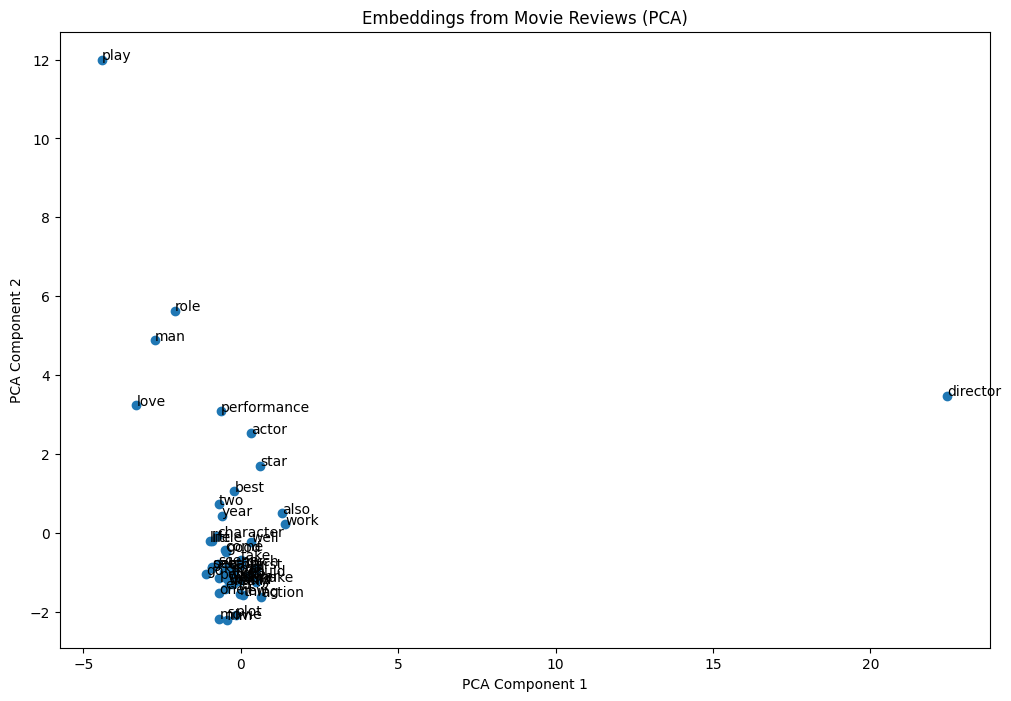

In [34]:
# Only visualise the embeddings of the most common words in the corpus
most_common_sppmi_svd_embeddings_ht = np.array([sppmi_svd_embeddings_ht[sppmi_svd_words_to_ids_ht[word]] for word in most_common_words])    # Use the unique int id of the word to get the corresponding embedding (with the words_to_id mapping)
visualise_embeddings(embeddings=most_common_sppmi_svd_embeddings_ht, words=most_common_words, filename="sppmi_svd_ht_pca_visualisation")

#### Nearest Neighbours

In [11]:
# Check nearest neighbours
SPPMI_SVD_TOPN = 10

for word in TEST_WORDS:
  print(f"{SPPMI_SVD_TOPN} nearest neighbours to {word}:")
  print(sppmi_svd_nearest_neighbours(embeddings=sppmi_svd_embeddings_ht, words_to_ids=sppmi_svd_words_to_ids_ht, target_word=word, topn=SPPMI_SVD_TOPN))
  print()

10 nearest neighbours to film:
[('movie', 0.8806698322296143), ('made', 0.8380125761032104), ('many', 0.8197451829910278), ('could', 0.8094170093536377), ('much', 0.8029585480690002), ('one', 0.7991598844528198), ('even', 0.7987421154975891), ('really', 0.7939698696136475), ('would', 0.7869608998298645), ('first', 0.7846642136573792)]

10 nearest neighbours to like:
[('one', 0.7953758835792542), ('really', 0.7865555286407471), ('know', 0.779260516166687), ('look', 0.7718312740325928), ('even', 0.7717165350914001), ('thing', 0.7710414528846741), ('bad', 0.745314359664917), ('movie', 0.7440394163131714), ('good', 0.7402405142784119), ('see', 0.7375472784042358)]

10 nearest neighbours to good:
[('well', 0.8275624513626099), ('one', 0.8185980319976807), ('really', 0.8182766437530518), ('time', 0.789311945438385), ('much', 0.7866829037666321), ('bad', 0.786185622215271), ('make', 0.7831035852432251), ('even', 0.77897709608078), ('see', 0.7767965197563171), ('movie', 0.7681609392166138)]

1